In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sb
import pandas as pd
import epidemic_model_classes_numba as epi_mod
from scipy.integrate import odeint
import scipy.stats as st
from scipy.stats import pearsonr
import os
from tqdm import tqdm

In [2]:
country = "India"
country_file_name = "india"
window_size = 30

log_flat = []
log_past = []

folders = os.listdir("../../logs")
folders.sort()
folders

for folder in folders:
    if "adaptive" in folder and "3_posts" in folder and country in folder and f"{window_size}_day" in folder:
        if "True" in folder:
            log_past.append("../../logs/"+folder+"/")
        else:
            log_flat.append("../../logs/"+folder+"/")

In [4]:
log_past = log_past[:20]
print(len(log_past))
log_past

20


['../logs/sdumont/log2021-08-24_18-00-07_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_18-24-18_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_18-47-58_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_19-12-39_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_19-38-46_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_20-10-54_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_20-34-23_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_20-56-58_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_21-17-26_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_21-35-37_adaptive_India_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/lo

In [7]:
log_flat = log_flat[:20]
print(len(log_flat))
log_flat

20


['../logs/sdumont/log2021-08-24_20-08-36_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_20-11-40_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_20-14-30_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_20-17-28_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_20-20-49_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-03_21-54-44_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-03_21-57-12_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-03_21-59-54_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-03_22-02-36_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-03_22-05-39_adaptive_India_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/

In [8]:
if country not in os.listdir("figures"):
    os.mkdir(f"figures/{country}")
if str(window_size) not in os.listdir(f"figures/{country}"):
    os.mkdir(f"figures/{country}/{str(window_size)}")

In [9]:
n_post = len(os.listdir(log_flat[0]))-1
days_folders = os.listdir(log_flat[0]+f"/Posterior1/{country}/SEIRD2")
for i in range(len(days_folders)):
    days_folders[i] = int(days_folders[i].split("_")[0])
days_folders.sort()
n_window = len(days_folders)

print(n_post)
print(n_window)
print(days_folders)

3
81
[30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430]


In [10]:
seird = epi_mod.SEIRD2

In [11]:
x_dat_flat = np.empty((len(log_flat), n_window), dtype=object)
y_fit_flat = np.empty((len(log_flat), n_window), dtype=object)
y_pred_flat = np.zeros((len(log_flat), n_window, 10, 2))

x_dat_past = np.empty((len(log_past), n_window), dtype=object)
y_fit_past = np.empty((len(log_past), n_window), dtype=object)
y_pred_past = np.zeros((len(log_past), n_window, 10, 2))

flat_params = np.zeros((len(log_flat), n_window, 8))
rmsd_flat_fit = np.zeros((len(log_flat), n_window))
rmsd_flat_pred = np.zeros((len(log_flat), n_window))
rmsd_flat_list = np.zeros((len(log_flat), n_window, 10, 2))
flat_tolerances = np.zeros((len(log_flat), n_post, n_window))

past_params = np.zeros((len(log_flat), n_window, 8))
rmsd_past_fit = np.zeros((len(log_flat), n_window))
rmsd_past_pred = np.zeros((len(log_flat), n_window))
rmsd_past_list = np.zeros((len(log_flat), n_window, 10, 2))
past_tolerances = np.zeros((len(log_flat), n_post, n_window))

post_flat_size = np.zeros((len(log_flat), n_window), dtype=np.int64)
post_past_size = np.zeros((len(log_past), n_window), dtype=np.int64)

In [12]:
for log_idx in range(len(log_flat)):
    for window in tqdm(range(n_window)):
        data = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")
        for i in range(1, data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] < data[i-1,j]:
                    data[i,j] = data[i-1,j]
        np.savetxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt", data)
        
        x_dat_flat[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:,0]
        y_fit_flat[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:-10,1:]
        y_pred_flat[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[-10:,1:]
        
        log = open(log_flat[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
        rmsd_flat_list[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/val_error.txt")
        flat_params[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/best_params.txt")
        log_text = log.read().split("\n")
        
        for line in log_text:
            if "Weighted RMSD:" in line:
                rmsd_flat_fit[log_idx, window] = float(line.split(" ")[-1])
            if "RMSD for validation data:" in line:
                rmsd_flat_pred[log_idx, window] = float(line.split(" ")[-1])
            if "Training window size:" in line:
                    post_flat_size[log_idx, window] = int(line.split(" ")[-1])
        
        for post in range(n_post):
            log = open(log_flat[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
            
            log_text = log.read().split("\n")
            
            for line in log_text:
                if "Tolerance:" in line:
                    flat_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
            log = open(log_flat[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")

            for line in log_text:
                if "Tolerance:" in line:
                    flat_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
for log_idx in range(len(log_past)):
    for window in tqdm(range(n_window)):
        data = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")
        for i in range(1, data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] < data[i-1,j]:
                    data[i,j] = data[i-1,j]
        np.savetxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt", data)
        
        x_dat_past[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:,0]
        y_fit_past[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:-10,1:]
        y_pred_past[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[-10:,1:]
        
        log = open(log_past[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
        rmsd_past_list[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/val_error.txt")
        past_params[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/best_params.txt")
        log_text = log.read().split("\n")
        
        for line in log_text:
            if "Weighted RMSD:" in line:
                rmsd_past_fit[log_idx, window] = float(line.split(" ")[-1])
            if "RMSD for validation data:" in line:
                rmsd_past_pred[log_idx, window] = float(line.split(" ")[-1])
            if "Training window size:" in line:
                post_past_size[log_idx, window] = int(line.split(" ")[-1])
        
        for post in range(n_post):
            log = open(log_past[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
            
            log_text = log.read().split("\n")
            
            for line in log_text:
                if "Tolerance:" in line:
                    past_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
            log = open(log_past[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")

            for line in log_text:
                if "Tolerance:" in line:
                    past_tolerances[log_idx, post, window] = float(line.split(" ")[-1])

100%|███████████████████████████████████████████| 81/81 [00:02<00:00, 33.40it/s]


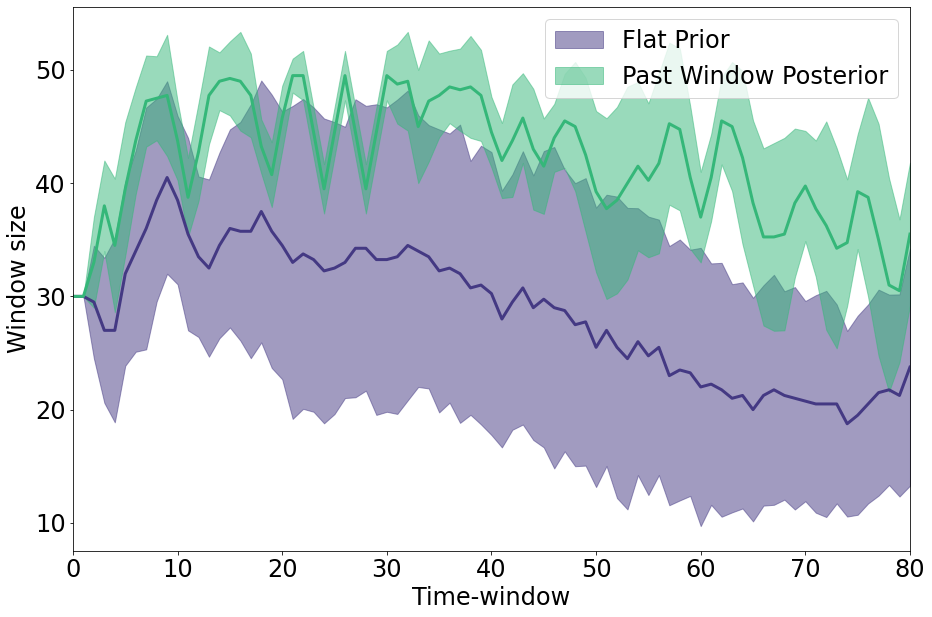

In [15]:
plt.figure(figsize=(15,10))
plt.plot(np.mean(post_flat_size, axis=0), lw=3, color=sb.color_palette("viridis", 5)[0])
plt.fill_between(np.arange(n_window), np.mean(post_flat_size, axis=0)-np.std(post_flat_size, axis=0), np.mean(post_flat_size, axis=0)+np.std(post_flat_size, axis=0), color=sb.color_palette("viridis", 5)[0], label="Flat Prior", alpha=0.5)

plt.plot(np.mean(post_past_size, axis=0), lw=3, color=sb.color_palette("viridis", 5)[3])
plt.fill_between(np.arange(n_window), np.mean(post_past_size, axis=0)-np.std(post_past_size, axis=0), np.mean(post_past_size, axis=0)+np.std(post_past_size, axis=0), color=sb.color_palette("viridis", 5)[3], label="Past Window Posterior", alpha=0.5)

plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0, n_window-1)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("Window size", fontsize=24)
plt.savefig(f"figures/{country}/{window_size}/{country_file_name}_{window_size}_window_size.png", dpi=300, bbox_inches="tight")

In [16]:
print(np.mean(np.std(post_flat_size, axis=0)))
print(np.mean(np.std(post_past_size, axis=0)))

10.617953750449038
4.9007961637699236


Flat 0.4286379981481481
Past 0.01692366049382716


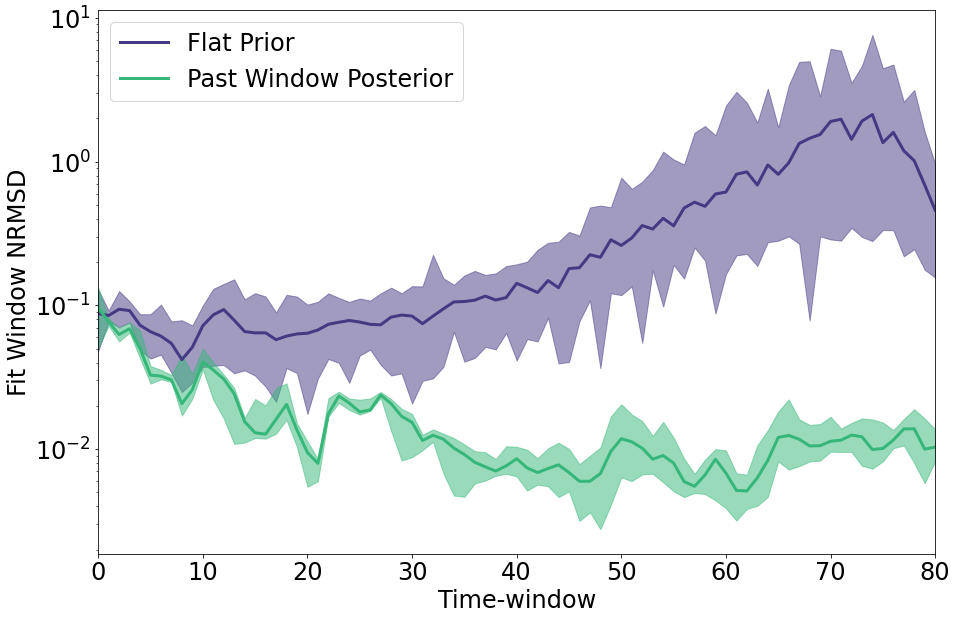

In [18]:
plt.figure(figsize=(15,10))
plt.plot(np.mean(rmsd_flat_fit, axis=0), lw=3, color=sb.color_palette("viridis", 5)[0], label="Flat Prior")
plt.fill_between(np.arange(len(rmsd_flat_fit[0])), np.min(rmsd_flat_fit, axis=0), np.max(rmsd_flat_fit, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[0])
plt.plot(np.mean(rmsd_past_fit, axis=0), lw=3, color=sb.color_palette("viridis", 5)[3], label="Past Window Posterior")
plt.fill_between(np.arange(len(rmsd_flat_fit[0])), np.min(rmsd_past_fit, axis=0), np.max(rmsd_past_fit, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[3])
plt.legend(loc="upper left", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0, n_window-1)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("Fit Window NRMSD", fontsize=24)
plt.yscale("log")
plt.savefig(f"figures/{country}/{window_size}/{country_file_name}_{window_size}_fit_window_nrmsd.png", dpi=300, bbox_inches="tight")
print("Flat", np.mean(rmsd_flat_fit))
print("Past", np.mean(rmsd_past_fit))

Flat 1.9199475185185186
Past 0.22091388209876545


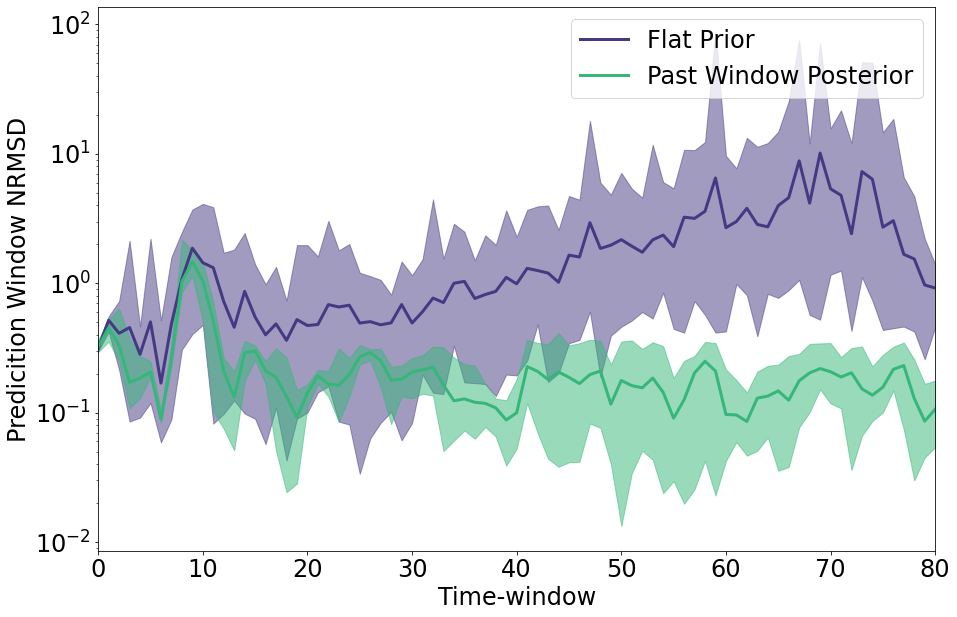

In [19]:
plt.figure(figsize=(15, 10))
plt.plot(np.mean(rmsd_flat_pred, axis=0), lw=3, color=sb.color_palette("viridis", 5)[0], label="Flat Prior")
plt.fill_between(np.arange(len(rmsd_flat_pred[0])), np.min(rmsd_flat_pred, axis=0), np.max(rmsd_flat_pred, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[0])
plt.plot(np.mean(rmsd_past_pred, axis=0), lw=3, color=sb.color_palette("viridis", 5)[3], label="Past Window Posterior")
plt.fill_between(np.arange(len(rmsd_flat_pred[0])), np.min(rmsd_past_pred, axis=0), np.max(rmsd_past_pred, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[3])
plt.legend(loc="upper right", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0, n_window-1)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("Predicition Window NRMSD", fontsize=24)
plt.yscale("log")
plt.savefig(f"figures/{country}/{window_size}/{country_file_name}_{window_size}_pred_window_nrmsd.png", dpi=300, bbox_inches="tight")
print("Flat", np.mean(rmsd_flat_pred))
print("Past", np.mean(rmsd_past_pred))

In [20]:
rmsd_flat_list_norm = np.abs((y_pred_flat[:,:,1:]-rmsd_flat_list[:,:,1:])-(y_pred_flat[:,:,:-1]-rmsd_flat_list[:,:,:-1])-(y_pred_flat[:,:,1:]-y_pred_flat[:,:,:-1]))/(y_pred_flat[:,:,1:]-y_pred_flat[:,:,:-1]+1)
rmsd_past_list_norm = np.abs((y_pred_past[:,:,1:]-rmsd_past_list[:,:,1:])-(y_pred_past[:,:,:-1]-rmsd_past_list[:,:,:-1])-(y_pred_past[:,:,1:]-y_pred_past[:,:,:-1]))/(y_pred_past[:,:,1:]-y_pred_past[:,:,:-1]+1)

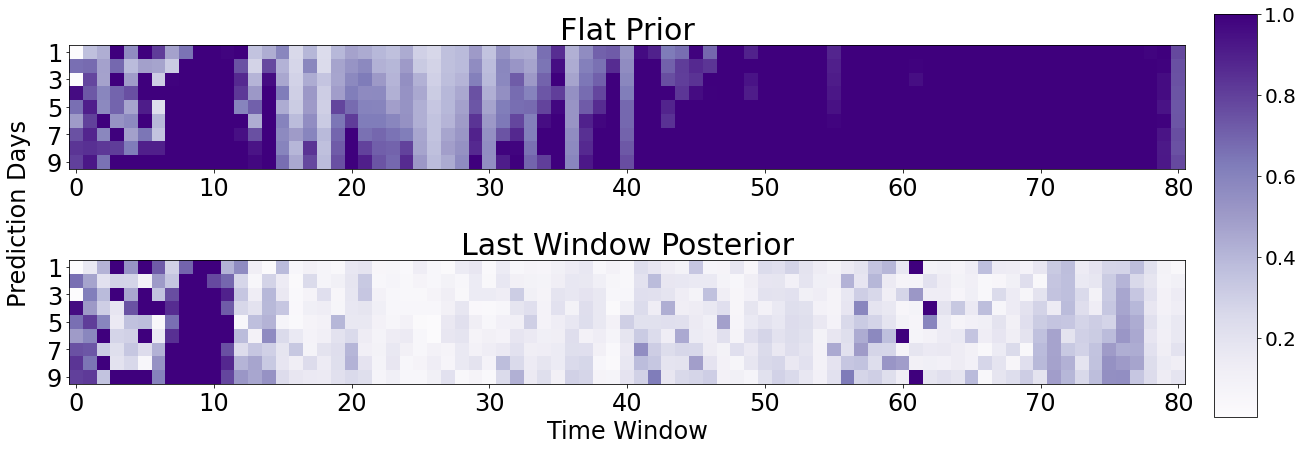

In [21]:
# plt.rcParams.update({"font.size":36})
fig = plt.figure(figsize=(20,7))
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,1)
pl = plt.imshow(np.mean(rmsd_flat_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples")
plt.yticks(range(0,10,2), labels=range(1,11,2), fontsize=24)
plt.xticks(fontsize=24)
plt.title("Flat Prior", fontsize=30)
plt.subplot(2,1,2)
plt.imshow(np.mean(rmsd_past_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples")
plt.yticks(range(0,10,2), labels=range(1,11,2), fontsize=24)
plt.xticks(fontsize=24)
plt.title("Last Window Posterior", fontsize=30)
plt.xlabel("Time Window", fontsize=24)
plt.text(-5, 2.5, "Prediction Days", rotation="vertical", fontsize=24)
cb_ax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
cb = fig.colorbar(pl, cax=cb_ax)
cb.ax.tick_params(labelsize=20)
plt.savefig(f"figures/{country}/{window_size}/{country_file_name}_{window_size}_heatmap.png", dpi=300, bbox_inches="tight")

In [16]:
pearsonr(rmsd_flat_fit.flatten(), rmsd_flat_pred.flatten())

(0.36870166273063987, 3.9310275103333e-15)

In [17]:
pearsonr(rmsd_past_fit.flatten(), rmsd_past_pred.flatten())

(0.31237823950449684, 4.5057998504231205e-11)

---

# Subplots - Windows

In [18]:
plt.subplots(int(np.ceil(n_window/8)), 8, figsize=(40, 50))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

y0 = np.zeros(5)

for i in range(n_window, int(np.ceil(n_window/8))*8):
    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.axis("off")

for i in tqdm(range(n_window)):
    y_fit = np.zeros((len(log_flat), 60))
    x_len = 0
    x_max_len_idx = -1
    
    for log_idx in range(len(log_flat)):
        if len(x_dat_flat[log_idx, i]) > x_len:
            x_len = len(x_dat_flat[log_idx, i])
            x_max_length_idx = log_idx
        
        y0[-1] = y_fit_flat[log_idx, i][0,1]
        y0[-2] = y_fit_flat[log_idx, i][0,0] - y0[-1]
        
        y_fit[log_idx,-len(x_dat_flat[log_idx, i]):] = seird.infected_dead(x_dat_flat[log_idx, i], flat_params[log_idx, i], y0)[0]
    
    y_fit_avg = np.zeros(x_len)
    y_fit_std = np.zeros(x_len)
    
    for j in range(x_len):
        y = []
        for k in range(len(log_flat)):
            if y_fit[k,j-x_len] != 0:
                y.append(y_fit[k,j-x_len])
        y_fit_avg[j] = np.mean(y)
        y_fit_std[j] = np.std(y)

    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.plot(x_dat_flat[x_max_length_idx, i][:-10], y_fit_flat[x_max_length_idx, i][:,0], "o", ms=3, c="k")
    plt.plot(x_dat_flat[x_max_length_idx, i][-10:], y_pred_flat[x_max_length_idx, i,:,0], "o", ms=3, c="#808080")
    plt.ticklabel_format(axis="y", scilimits=(0,1))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().yaxis.get_offset_text().set_fontsize(10)
    
    plt.title(f"Time-window {x_dat_flat[x_max_length_idx, i][0]:.0f}-{x_dat_flat[x_max_length_idx, i][-1]:.0f}", fontsize=18)
    
    plt.plot(x_dat_flat[x_max_length_idx, i], y_fit_avg, lw=2)
    plt.fill_between(x_dat_flat[x_max_length_idx, i], y_fit_avg-y_fit_std, y_fit_avg+y_fit_std, alpha=0.3)
    
    plt.vlines(np.mean(x_dat_flat[x_max_length_idx, i][-11:-9]), y_fit_flat[x_max_length_idx, i][0,0], max(y_pred_flat[x_max_length_idx, i,-1,0], y_fit_avg[-1]+y_fit_std[-1]), color="#202020", ls="--", lw=1)
    
plt.savefig(f"figures/{country}/{window_size}/{country_file_name}_{window_size}_windows_flat.png", dpi=300, bbox_inches="tight")
plt.close()

100%|██████████| 85/85 [00:11<00:00,  7.35it/s]


In [19]:
plt.subplots(int(np.ceil(n_window/8)), 8, figsize=(40, 50))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

y0 = np.zeros(5)

for i in range(n_window, int(np.ceil(n_window/8))*8):
    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.axis("off")

for i in tqdm(range(n_window)):
    y_fit = np.zeros((len(log_past), 60))
    x_len = 0
    x_max_len_idx = -1
    
    for log_idx in range(len(log_past)):
        if len(x_dat_past[log_idx, i]) > x_len:
            x_len = len(x_dat_past[log_idx, i])
            x_max_length_idx = log_idx
        
        y0[-1] = y_fit_past[log_idx, i][0,1]
        y0[-2] = y_fit_past[log_idx, i][0,0] - y0[-1]
        
        y_fit[log_idx,-len(x_dat_past[log_idx, i]):] = seird.infected_dead(x_dat_past[log_idx, i], past_params[log_idx, i], y0)[0]
    
    y_fit_avg = np.zeros(x_len)
    y_fit_std = np.zeros(x_len)
    
    for j in range(x_len):
        y = []
        for k in range(len(log_past)):
            if y_fit[k,j-x_len] != 0:
                y.append(y_fit[k,j-x_len])
        y_fit_avg[j] = np.mean(y)
        y_fit_std[j] = np.std(y)

    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.plot(x_dat_past[x_max_length_idx, i][:-10], y_fit_past[x_max_length_idx, i][:,0], "o", ms=3, c="k")
    plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_pred_past[x_max_length_idx, i, :,0], "o", ms=3, c="#808080")
    plt.ticklabel_format(axis="y", scilimits=(0,1))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().yaxis.get_offset_text().set_fontsize(10)
    
    plt.title(f"Time-window {x_dat_past[x_max_length_idx, i][0]:.0f}-{x_dat_past[x_max_length_idx, i][-1]:.0f}", fontsize=18)
    
    plt.plot(x_dat_past[x_max_length_idx, i], y_fit_avg, lw=2)
    plt.fill_between(x_dat_past[x_max_length_idx, i], y_fit_avg-y_fit_std, y_fit_avg+y_fit_std, alpha=0.3)
    
    plt.vlines(np.mean(x_dat_past[x_max_length_idx, i][-11:-9]), y_fit_past[x_max_length_idx, i][0,0], max(y_pred_past[x_max_length_idx, i,-1,0], y_fit_avg[-1]+y_fit_std[-1]), color="#202020", ls="--", lw=1)

plt.savefig(f"figures/{country}/{window_size}/{country_file_name}_{window_size}_windows_past.png", dpi=300, bbox_inches="tight")
plt.close()

100%|██████████| 85/85 [00:03<00:00, 22.88it/s]
